In [91]:
#!curl https://raw.githubusercontent.com/alexeygrigorev/minsearch/main/minsearch.py

In [32]:
#!pipenv install seaborn 

In [265]:
#!pipenv install spacy

In [269]:
#!python -m spacy download en_core_web_sm


In [272]:
from bs4 import BeautifulSoup
import glob
import pandas as pd
import numpy as np
import re
import time
import seaborn as sns
# import tqdm
from tqdm.auto import tqdm
#pd.set_option('display.max_colwidth', None)




## Step 1: Prepare documents (Extracting and Transforming)

## Ingestion
This was extracted from telegram channel conversation (from 14-2-2019 to 14-9-2024) on diet and the data was in form of many html documents.

In [106]:
# Load HTML files
def wrangle(paths):
    dfs=[]
    # forward fill after removed text from date column
    def clean_date(date):
                # Regular expression pattern for valid dates (e.g., '13 March 2019')
                pattern = r'^\d{1,2}\s\w+\s\d{4}$'  # Matches 'DD Month YYYY'
                if re.match(pattern, date):
                    return date
                else:
                    return None  # Replace invalid dates with None
    
    for html in paths:
        
        with open( html, 'r', encoding='utf-8') as file:
            soup = BeautifulSoup(file, 'html.parser')
    
            # Extract messages
            messages = []
            for message in soup.find_all('div', class_='message'):
                date = message.find('div', class_='body details').text.strip() if message.find('div', class_='body details') else None
                time = message.find('div', class_='date').text.strip() if message.find('div', class_='date') else None
                user = message.find('div', class_='from_name').text.strip() if message.find('div', class_='from_name') else None
                content = message.find('div', class_='text').text.strip() if message.find('div', class_='text') else None
                messages.append({"Date":date, "Time":time, "User": user,"Content": content})
            
            # Convert to DataFrame
            df = pd.DataFrame(messages)
            # fill in the na values by forward fill for dates
            df['Date']=df['Date'].ffill()
            # transform the date column by replacing any message about 'someone invited someone' in the group or removed someone with none
            df['Date']=df['Date'].apply(clean_date)
            df['Date']=df['Date'].ffill()
            # drop rows that have three nans. It is the date heading
            df=df.dropna(thresh=2)
            # forward fill user where nan
            df['User']=df['User'].ffill()
            # drop empty content it is usually pics
            df=df.dropna(subset='Content')
            dfs.append(df)
            print(df.head(1))
            
    return dfs

In [107]:
# file pattern
file_pattern=r'C:\Users\user\Documents\LLM Zoomcamp\Project\data\raw_data\messages*.html'

In [118]:
# Get a list of all matching files
files = glob.glob(file_pattern)  # we matched 438 files
len(files)
# for f in files:
#     print(f)

438

In [147]:
import time

t0 = time.time()
# Import html files using wrangle function, transform and combine them
#dfs=wrangle(files)
t1 = time.time()
total = t1-t0
# concat dataframes
#df=pd.concat(dfs, ignore_index=True)

df=df.dropna()
# Save to CSV
# df.to_csv('../data/clean_data/combo_conversations_latest.csv', index=False)
# df.isnull().sum()

In [148]:
print(total/60)

0.0


In [283]:
# import csv file
df = pd.read_csv('../data/clean_data/combo_conversations_latest.csv', parse_dates=['Date'])
#df.info()
df['Date']

0        2019-02-14
1        2019-02-14
2        2019-02-14
3        2019-02-14
4        2019-02-14
            ...    
414123   2021-04-28
414124   2021-04-28
414125   2021-04-28
414126   2021-04-28
414127   2021-04-28
Name: Date, Length: 414128, dtype: datetime64[ns]

In [284]:
df.head()

,Date,Time,User,Content
0,2019-02-14,08:02,Silmavi,Hello!
1,2019-02-14,08:05,Deleted Account,"sooo, detox finished when? 😄"
2,2019-02-14,08:05,Silmavi,Here we can talk about Aajonus?
3,2019-02-14,08:07,Deleted Account,Detox! Hell yeah Aajonus
4,2019-02-14,08:08,Silmavi,😂😂😂😂


In [285]:
# Set the 'Date' column as the index of the DataFrame
df.set_index('Date', inplace=True)
# Sort the DataFrame by the index (Date) so that there is good flow in a chronological order.
df.sort_index(inplace=True)
df.tail()

,Time,User,Content
Date,,,
2024-09-14,03:15,Mziskaci,are wild animals safe to eat raw?
2024-09-14,01:16,Adrian Marquelos,I saw this on eat raw meat channel. I wouldn’t...
2024-09-14,00:31,Colby🐍,You got vaxxed even after listening to aajonus...
2024-09-14,08:00,Gabriel Olivares,Is it possible for a detox to last 4 months or...
2024-09-14,03:50,Marcel,What to do with 10L of raw milk that are alrea...


Due to short sentences in each row, I decided to combine all the rows related to the same speaker into one chunk.

In [286]:
# Chunking by User 
chunked_data = []
current_chunk = []
t0 = time.time()
for i in range(len(df)):
    if i == 0 or df.iloc[i]['User'] == df.iloc[i-1]['User']:
        current_chunk.append(df.iloc[i]['Content'])
    else:
        chunked_data.append(" ".join(current_chunk))
        current_chunk = [df.iloc[i]['Content']]

# Append the last chunk
if current_chunk:
    chunked_data.append(" ".join(current_chunk))
print(type(chunked_data))
# Create a new DataFrame with chunked data
chunked_df = pd.DataFrame({'Chunked_Content': chunked_data})

# Save the chunked data
chunked_df.to_csv('../data/clean_data/thread_chunked_conversations.csv', index=False)

t1 = time.time()
total = t1-t0
print(total/60)


<class 'list'>
0.7619206786155701


In [287]:
chunked_df=pd.read_csv('../data/clean_data/thread_chunked_conversations.csv')
chunked_df

,Chunked_Content
0,Hello! when you eat it alone? Good idea to eat...
1,Yesterday I had nausea after several hours pas...
2,So when you have enough fat you feel nausea if...
3,"So guys, water=bad?"
4,I have dry skin even if i drink twice lubricat...
...,...
241858,are wild animals safe to eat raw?
241859,I saw this on eat raw meat channel. I wouldn’t...
241860,You got vaxxed even after listening to aajonus...
241861,Is it possible for a detox to last 4 months or...


I decided to chunk any question with its answers together in a chunk

In [288]:
# create new variables

chunked_data = []
current_chunk = []
question_found = False

for i in range(len(df)):
    message = df.iloc[i]['Content']
    
    # Check if the message is a question
    if message.endswith('?'):
        # If there's already a chunk being built (a question and its answers), finalize it
        if current_chunk:
            chunked_data.append(" ".join(current_chunk))
        # Start a new chunk with the current question
        current_chunk = [message]
        question_found = True
    else:
        # If the message isn't a question, but a question has been found, add it as an answer
        if question_found:
            current_chunk.append(message)
        # If no question has been found yet, skip this message or handle it as needed
        # (e.g., you could append it to the previous chunk if desired)

# Append the last chunk after the loop, if it exists
if current_chunk:
    chunked_data.append(" ".join(current_chunk))

# Create a new DataFrame with the chunked data
chunked_QandA = pd.DataFrame({'Chunked_Content': chunked_data})

# Save the chunked data to a CSV file
chunked_QandA.to_csv('../data/clean_data/question_answer_chunked_conversations.csv', index=False)


In [289]:
# function for splitting each chunk into sentences
# Function to split text into sentences
def split_into_sentences(text):
    sentences = re.split(r'(?<=[.!?]) +', text)
    return sentences


In [290]:
# load data
chunked_QandA=pd.read_csv('../data/clean_data/question_answer_chunked_conversations.csv')
# Count the numbers of sentences per row
chunked_QandA['number of sentences']=[len(x) for x in chunked_QandA['Chunked_Content'].apply(split_into_sentences)]
chunked_QandA['number of words']=[len(x.split()) for x in chunked_QandA['Chunked_Content']]
# get all information about the spread of the number of sentences
chunked_QandA['number of sentences'].describe()  # mean is 5 sentences
#chunked_QandA.sort_values(by=['number of sentences'], ascending=False)


count    48913.000000
mean         5.391573
std          6.233725
min          1.000000
25%          2.000000
50%          3.000000
75%          6.000000
max        118.000000
Name: number of sentences, dtype: float64

In [291]:
chunked_QandA['number of words'].describe()

count    48913.000000
mean       104.978308
std        141.088247
min          1.000000
25%         22.000000
50%         58.000000
75%        132.000000
max       3512.000000
Name: number of words, dtype: float64

In [292]:
chunked_QandA[chunked_QandA['number of sentences']==2]

,Chunked_Content,number of sentences,number of words
0,when you eat it alone? Good idea to eat it onc...,2,69
3,"So guys, water=bad? I have dry skin even if i ...",2,14
7,what is aajonos saying about fasting? Not to lol,2,9
9,Cheese and honey btw meals? Sounds good Just c...,2,80
10,How you make it? Just put the milk in glass ja...,2,40
...,...,...,...
48897,I thought eye color is genetic? well i don't k...,2,78
48898,What? I don't really want to spend years doing...,2,17
48903,"Rom, any more info on making your hot tub prim...",2,25
48905,Is there anything else for this? Okay will che...,2,43


### Compare the three methods:
- Taking the raw conversations was not the best option as each chunk was too short to get context
- Threaded chunks by grouping each user speech would less context and would not link each question to its relevant answer
- Grouping questions with their answer was the best option since the aim was for this to be health adviser.

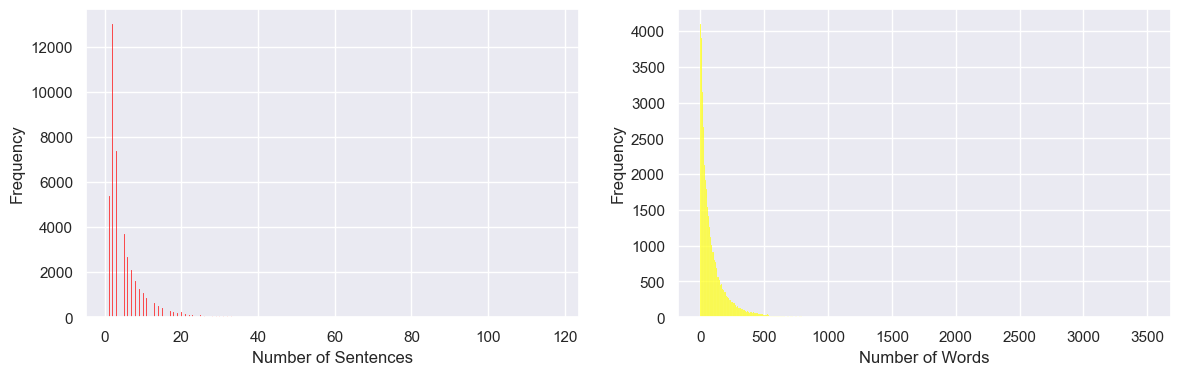

In [293]:
# number of sentences and words per chunk
import matplotlib.pyplot as plt
sns.set_theme(style="darkgrid")
fig, axs = plt.subplots(1, 2, figsize=(14,4))

sns.histplot(data=chunked_QandA, x='number of sentences',color="red", ax=axs[0])
sns.histplot(data=chunked_QandA, x='number of words',color='yellow', ax=axs[1])
# # Adding labels and legend
# Set label for x-axis 
axs[0].set_xlabel( "Number of Sentences" , size = 12 ) 
axs[1].set_xlabel( "Number of Words" , size = 12 ) 
# Set label for y-axis 
axs[0].set_ylabel( "Frequency" , size = 12 ) 
axs[1].set_ylabel( "Frequency" , size = 12 ) 
  

# Display figure 
plt.show() 



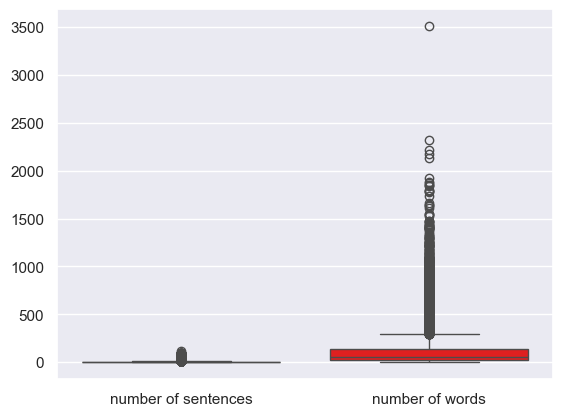

In [294]:
#sns.boxplot(data=chunked_QandA, x='number of sentences')
sns.boxplot(data=chunked_QandA[['number of sentences', 'number of words']],color="red")
# Display the plot
plt.show()

#### Amending the chunk sizes
This is important because different has limit of number of token it can handle
Model Context Window: Most transformer-based models, like GPT-3, have a context window that limits the number of tokens (words, punctuation marks, etc.)
they can process at once. For example, GPT-3 has a context window of around 4,000 tokens, 
while smaller models like GPT-2 might have around 1,024 tokens.
Comparison between using
sentences = re.split(r'(?<=[.!?]) +', text)  this one broken sentences if there was a punctuation and one or more spaces after
or sentences = re.split(r'(?<=[.!?])\s*', text) this one broke sentence where there was only one of the punctuation marks with or without spaces after.
I decided to choose the first method because the second method was one word quotes as two senteces. For examples 'How?' was counted as two sentences.
'I said.....' was counted as few sentences. Now min number of sentences will be 3 and maximum will be 50.

In [295]:
# examine the longest sentence
with pd.option_context('display.max_colwidth', None):
  display(chunked_QandA[chunked_QandA['number of sentences']==118][['Chunked_Content', 'number of words']])

Chunked_Content  \
8329  Does John think there is no autoimmune disease?  but why when people use the autoimmune protocol do they get rid of autoimmune diseases? No such thing as autoimmune QA_LA_2008_08_24 01:43:45"Q: How do you cure autoimmune diseases ?A: There is no such thing as autoimmune, that is a manufactured bullshit story created by the pharmaceutical and medical community, that is like. Okay, the Russians are coming,that means that now i can go to war, that means that i can make tanks, bullets, planes, bombs, nuclear weapons, that means that now i can spend all this energy on arming myself because the Russians are going to take over, that is the reason for a war effort for 30 years, the Russians are coming. The body never turns against itself. Ever, ever, ever, turn against itself. You would never heal if you had that problem. You go so many poisons in your body that is deteriorating the cell. Bacteria, parasites, virus none of them tear the body down and work against you. You don't fight your own blood unless it has been poisoned, contaminated. And then is not going after the cell ,because it is a cell, because it is you, it is going after because it is contaminated. Autoimmune, get rid of that, that is misnomer." There is no such thing as autoimmune disease. The body never attacks itself. It was made up by the pharmaceutical companies so that they could sell more supplements and drugs. Body tries to get rid of toxins in the body and they call it autoimmune. GeneticsQA_LA_2013_01_27 00:21:10A: So your question was about genetics – whether you’ll have the same problems with Alzheimer’s and dementia as your parents. If you continue to contaminate your brain, you will have those and you’ll have glimpses of them when you detox. Just remember, your disease is your detoxification. Your disease isn’t the problem, it’s the cure. What you have to do is aid the body in detoxifying. You have to assist the detoxification process that creates those symptoms. It’s the contaminants that are causing the problems, not the body attacking itself. The most ludicrous thing in the world is believing your body is attacking itself. There is no such thing as an autoimmune system. The pharmaceutical houses use that to scare the doctors who use that to completely scare you. Doctors don’t know any better. They accept this mythological fairytale - this nonsense – horror B-Class movies from Hollywood - as truth. Ridiculous. You have a lymphatic system. The lymphatic system is responsible for removing all waste in the body. The bacteria in the body are responsible for breaking down dead cells, digestion and everything. The body is 99.99% bacteria. You have [something like] 360 bacteria to each human gene. You’re barely 1% human. So the idea of destroying your bacteria is absurd. The bacteria will break down dead cells, recycle them if they can - re-digest them – and send the waste to the lymphatic system. The lymphatic system absorbs them. If you’re lacking all this bacteria with vaccines and antibiotics, the lymph system then has to take the dead cells, make a solvent to dissolve them, and discard the waste. All of it will be waste. It can’t recycle any of it. The lymphatic system can’t recycle any waste. Only bacteria, parasites and fungus can recycle – but mainly bacteria. So, if you eat a good diet and take care of yourself you won’t have dementia and Alzheimer’s. understood, thanks, this is interesting🙏 2010 05 23Q Even Himalayan salt? AV Even Himalayan. When you isolate sodium, one block this big…crystal this big is worth an atomic bomb, and that’s why they put iodine or potassium chloride with the salt, something like that so it won’t be explosive. What happens in your body - it creates all this breaking down of the food so it helps you digest your food, but not in a nice way. Plus, the sodium gets released in your blood and these explosions go off all the time. Now, normally a cell when it eats, it eats a smorgasbord of food. I hear now

In [296]:
# examine the chunk with highest number of words
with pd.option_context('display.max_colwidth', None):
  display(chunked_QandA[chunked_QandA['number of words']==3512][['Chunked_Content','number of sentences']])

Chunked_Content  \
5716  @vilt David what if one does not produce enough bile? Any ways to reverse that ? i found it in a drug which my gastroenterologist told me to take... that is literally a component of a vaccine, wtf too much of it builds up in my ear sometimes and impairs my hearing Yea, he wants to kill you They take a liquid, fill the tablespoon and measure how much there is of liquid. When you take the butter with tablespoon you have to do it the same way. @haku4207 1ml is 1g. @antonleiton thank you bro for the screenshots, this is a brilliant post and great summary I am too lazy to explain Different sites, show different results, some say it is 12g. You have to look at ml and convert it to grams @haku4207 Read all of this Like a hot bath? Water with a little salt, acv, milk ors.Exercise is discouraged except in the form of 2h normal activity (not sitting literally all day), or with the presence of too many activity rings in iris indicating a need to spend toxic volatile hormones made from toxic cholesterol (singing can replace 3x more effectively or at least in part though)Naps can be very beneficial.You can do the first 2h of sleeping in your hot bath. 5min after vegetable juice because the overacidity is greater at this moment of the day (from toxins dumping all night long and nervous system detoxing). [soon a post on animal food combinations with other types of foods]- If you have a heavy microbial detox, such as gangrene (fungal), mycelium, or parasitic, you need to be eating meat proteins for regeneration of cells, or you can end up having cysts, lupus, scars and holes.- Eating proteins before every 5h mark to avoid autophagy which is toxic in our condition (see this post https://www.facebook.com/groups/aajonus/permalink/10158334171744521/)- Right before sleeping, always have a good meal with plenty of proteins (mandatory because of above) and fat. Eating an egg may not be enough to put your to sleep or well/long enough, even a few eggs. Milkshakes, lubrication formula. Having some complete meat meal is optmal bceause it will be used for regeneration and in general can satisfy the most. You can follow a meat meal by a milkshake if you also need some alkalizing effect (you will feel the "breath" that courses through you indicating this).- "Every day is a new day.": if you ate meat or juice yesterday you still need a constant supply of it, and even throughout the day. Your blood is constantly being renewed.- Spend at least a few months rebuilding and avoiding most triggered detox (with certain formulas).- Do hot baths but not until you have some fat on you and have been rebuilding on primal for a few months at least. Prior to this do no more than about 45min at a max of 39-40°C.- After many years on the Primal Diet, you must cut out some plant matter and water, adapt the doses, or it will start being detrimental and hinder your digestion. Primal Diet is adapting to your condition and dynamic with an expected evolution.- Spend the morning getting balanced, and the afternoon for detox, avoid detox too late at night for better sleep.- Eat sugar foods (such as milk or honey) only after 6hours of being awake, so usually from 1pm in the afternoon. (because glycogen is made in the morning and it's better to make it from protein, otherwise it generates more AGEs throughout the days and leads to sticky blood and electrical signal in synapses).- Eat about 1/3 of fermented more detoxing foods to 2/3 fresher foods (rebuilding), except fermented milk which can be mild on detox and more power-providing.- Sip your fluids, don't guzzle/gulp them. Otherwise up to 30% (90% if it's water) of the H2O will separate, kill anaerobic bacteria, rush through GI tract and kidneys and strip mucus from them, leech nutrients on its way, leaving behind the separated nutrients that will be harder to digest (like from milk to cheese) and leave cells actually dehydrated.- If you are thirsty, you may need fats and/or solvents, but think about what 

### Most of the chunks are below  words each
I decided to have 3 sentences as the minimum and 50 sentences as the maximum per chunk

In [297]:
def split_large_chunks_by_sentences(text, min_sentences=3, max_sentences=50):
    sentences = re.split(r'(?<=[.!?]) +', text)
    chunks = []
    current_chunk = []

    for sentence in sentences:
        current_chunk.append(sentence)
        if len(current_chunk) >= max_sentences:
            chunks.append('. '.join(current_chunk))
            current_chunk = []

    # Add the last chunk
    if len(current_chunk) >= min_sentences:
        chunks.append('. '.join(current_chunk))
    
    # Handle the last chunk if it's below the minimum
    if current_chunk and len(current_chunk) < min_sentences:
        if chunks:
            chunks[-1] += '. ' + '. '.join(current_chunk)
        else:
            chunks.append('. '.join(current_chunk))
    
    return chunks

# applying the funtion to our dataframe
df = chunked_QandA

split_chunks = []
for i, row in df.iterrows():
    text = row['Chunked_Content']
    split_chunks.extend(split_large_chunks_by_sentences(text, min_sentences=3, max_sentences=50))

# Create a new DataFrame with split chunks
split_df = pd.DataFrame({'Chunked_Content': split_chunks})

# Save the split data to a new CSV
split_df.to_csv('../data/clean_data/QandA_split_conversations.csv', index=False)
# Counting the number of sentences
split_df['number of sentences'] = [len(x) for x in split_df['Chunked_Content'].apply(split_into_sentences)]
max_sentences = split_df['number of sentences'].max()
min_sentences = split_df['number of sentences'].min()

print(f"Max sentences: {max_sentences}")
print(f"Min sentences: {min_sentences}")

# Counting the number of words
split_df['number of words'] = [len(x.split()) for x in split_df['Chunked_Content']]
max_sentences = split_df['number of words'].max()
min_sentences = split_df['number of words'].min()

print(f"Max words: {max_sentences}")
print(f"Min words: {min_sentences}")
print(len(split_df))
split_df['number of sentences'].value_counts()
split_df['number of words'].value_counts()

Max sentences: 52
Min sentences: 1
Max words: 2347
Min words: 1
49006


number of words
6       791
7       788
5       735
8       722
9       711
       ... 
778       1
1034      1
876       1
1159      1
982       1
Name: count, Length: 985, dtype: int64

In [301]:
import spacy

nlp = spacy.load("en_core_web_sm")

def extract_keywords(text):
    doc = nlp(text)
    keywords = set()
    for token in doc:
        if token.is_stop == False and token.is_punct == False:
            keywords.add(token.lemma_)
    return list(keywords)
tqdm.pandas(desc='extract keywords')
split_df['Keywords'] = split_df['Chunked_Content'].progress_apply(extract_keywords)

# save it to a csv file.
split_df.to_csv('../data/clean_data/Final_QandA_split_conversations_with_keywords.csv', index=False)


extract keywords:   0%|          | 0/49006 [00:00<?, ?it/s]

In [303]:
df=pd.read_csv('../data/clean_data/Final_QandA_split_conversations_with_keywords.csv')
df

,Chunked_Content,number of sentences,number of words,Keywords
0,when you eat it alone?. Good idea to eat it on...,2,69,"['pass', 'meal', 'home', 'nausea', 'honey', 'w..."
1,So they ate clay?. Act Charcoal will do the jo...,5,34,"['pass', 'meal', 'job', 'cold', 'neutral', 'cl..."
2,So when you have enough fat you feel nausea if...,1,13,"['eat', 'nausea', 'fat', 'feel']"
3,"So guys, water=bad?. I have dry skin even if i...",2,14,"['twice', 'water', '=', 'drink', 'skin', 'guy'..."
4,@ubeats1 could you please advice any source/bo...,8,110,"['detoxification', 'meal', 'trouble', 'literat..."
...,...,...,...,...
49001,are wild animals safe to eat raw?,1,7,"['safe', 'raw', 'animal', 'eat', 'wild']"
49002,I saw this on eat raw meat channel.. I wouldn’...,3,41,"['talk', 'like', 'woman', 'sara', 'pay', 'chan..."
49003,You got vaxxed even after listening to aajonus...,1,12,"['vaxxe', 'year', 'aajonus', 'couple', 'listen..."
49004,Is it possible for a detox to last 4 months or...,1,26,"['symptom', 'mental', 'confusion', 'malaise', ..."


In [14]:
# create documents
documents =chunked_df_QandA.to_dict(orient='records')

In [15]:
documents[0:20]

[{'Chunked_Content': "when you eat it alone? Good idea to eat it once wuth honey and once alone My kids eat it with the meal.They aren't at home btw meals I will do it during week end Yesterday I had nausea after several hours passed from second meal.Today I had zero hunger until 20h+ passed after previous that meal Today I made only one typical meal enhanced with 4 egg yolks",
  'num of words': 69},
 {'Chunked_Content': 'So they ate clay? Act Charcoal will do the job? 4,5 h passed I feel neutral, zero hunger and body warmed itself to confort temperature. Before meal I felt colder than normal. Thx Ring',
  'num of words': 34},
 {'Chunked_Content': 'So when you have enough fat you feel nausea if you eat it?',
  'num of words': 13},
 {'Chunked_Content': 'So guys, water=bad? I have dry skin even if i drink twice lubrication formula',
  'num of words': 14},
 {'Chunked_Content': "@ubeats1 could you please advice any source/book/literature about detoxification? Besides Aajonuse's books? Funn

In [16]:
len(documents)

48913

In [17]:
import minsearch
import json

In [18]:
index = minsearch.Index(
    text_fields=["Chunked_Content"],
    keyword_fields=["User"]
)

In [19]:
index = minsearch.Index(
    text_fields=["Chunked_Content"],
    keyword_fields=[]
)

In [20]:
index

In [21]:
index.fit(documents)

In [22]:
def search(query):
    boost = {'Chunked_Content': 3.0}

    results = index.search(
        query=query,
        boost_dict=boost,
        num_results=5
    )

    return results

In [23]:
q = 'Is vegetable oil good for you?'

In [24]:
search(q)

[{'Chunked_Content': 'is olive oil a vegetable oil? Nope, fruit LOL Vegetable oil is any plant oil I would say',
  'num of words': 18},
 {'Chunked_Content': 'Can I give coconut oil to the vegetable juice?',
  'num of words': 9},
 {'Chunked_Content': 'what is the best oil to oil pull with and should i ferment the oil? Coconut oil',
  'num of words': 17},
 {'Chunked_Content': 'Or with vegetable juice?', 'num of words': 4},
 {'Chunked_Content': 'What’s a good coconut oil to get?', 'num of words': 7}]

## Step 2: Create Embeddings using Pretrained Models

In [44]:
# This is a new library compared to the previous modules. 
# Please perform "pip install sentence_transformers==2.7.0"
from sentence_transformers import SentenceTransformer

# if you get an error do the following:
# 1. Uninstall numpy 
# 2. Uninstall torch
# 3. pip install numpy==1.26.4
# 4. pip install torch
# run the above cell, it should work
model = SentenceTransformer("all-mpnet-base-v2")

C:\Users\user\.virtualenvs\Project-v4EWajkE\Lib\site-packages\sentence_transformers\cross_encoder\CrossEncoder.py:13: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm, trange
C:\Users\user\.virtualenvs\Project-v4EWajkE\Lib\site-packages\transformers\tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [46]:
# test it
len(model.encode("This is a simple sentence"))  # 768
a=model.encode("This is a simple sentence and that is a word and he went to schoool")
len(a)

768

In [47]:
# import tqdm
from tqdm.auto import tqdm
#created the dense vector using the pre-trained model
operations = []
t0 = time.time()
for doc in tqdm(documents):
    # Transforming the title into an embedding using the model
    doc["text_vector"] = model.encode(doc["Chunked_Content"]).tolist()
    operations.append(doc)
t1 = time.time()
total=t1-t0
print(f'{total/60} minutes')

  0%|          | 0/48913 [00:00<?, ?it/s]

170.59940267801284 minutes


In [25]:
#operations[0]

In [49]:
import pickle

# save dictionary to person_data.pkl file
with open('vectorized_data.pkl', 'wb') as fp:
    pickle.dump(operations, fp)
    print('dictionary saved successfully to byte file')

dictionary saved successfully to byte file


In [50]:
import json

print("Started writing dictionary to a file")
with open("vectorized_data.json", "w") as fp:
    json.dump(operations, fp)  # encode dict into JSON
print("Done writing dict into .json file")

Started writing dictionary to a file
Done writing dict into .txt file


In [65]:
import json

print("Started writing dictionary to a file")
with open("vectorized_data.txt", "w") as fp:
    json.dump(operations, fp)  # encode dict into JSON
print("Done writing dict into .txt file")

Started writing dictionary to a file
Done writing dict into .txt file


In [75]:
# Read dictionary pkl file
with open('vectorized_data.pkl', 'rb') as fp:
    data= pickle.load(fp)
    print('Person dictionary')
    print(data[0:2])
#len(data)

Person dictionary
[{'Chunked_Content': "when you eat it alone? Good idea to eat it once wuth honey and once alone My kids eat it with the meal.They aren't at home btw meals I will do it during week end Yesterday I had nausea after several hours passed from second meal.Today I had zero hunger until 20h+ passed after previous that meal Today I made only one typical meal enhanced with 4 egg yolks", 'num of words': 69, 'text_vector': [0.010721932165324688, -0.04281805828213692, 0.026193972676992416, -0.04524363949894905, -0.06520701199769974, 0.004439320880919695, -0.032076478004455566, -0.03642812743782997, 0.08497369289398193, 0.023226218298077583, 0.025575537234544754, -0.025730609893798828, -0.0038772625848650932, -0.05311669781804085, 0.005834613926708698, 0.06900814175605774, -0.010103747248649597, 0.05677575618028641, -0.006016832776367664, 0.04230250418186188, -0.025512732565402985, -0.030057258903980255, -0.03446881100535393, 0.04153470695018768, 0.01937882974743843, -0.0226717684

In [56]:
# Open the file for reading
with open("vectorized_data.json", "r") as fp:
    # Load the dictionary from the file
    person_dict = json.load(fp)

# Print the contents of the dictionary
print(person_dict[0])

{'Chunked_Content': "when you eat it alone? Good idea to eat it once wuth honey and once alone My kids eat it with the meal.They aren't at home btw meals I will do it during week end Yesterday I had nausea after several hours passed from second meal.Today I had zero hunger until 20h+ passed after previous that meal Today I made only one typical meal enhanced with 4 egg yolks", 'num of words': 69, 'text_vector': [0.010721932165324688, -0.04281805828213692, 0.026193972676992416, -0.04524363949894905, -0.06520701199769974, 0.004439320880919695, -0.032076478004455566, -0.03642812743782997, 0.08497369289398193, 0.023226218298077583, 0.025575537234544754, -0.025730609893798828, -0.0038772625848650932, -0.05311669781804085, 0.005834613926708698, 0.06900814175605774, -0.010103747248649597, 0.05677575618028641, -0.006016832776367664, 0.04230250418186188, -0.025512732565402985, -0.030057258903980255, -0.03446881100535393, 0.04153470695018768, 0.01937882974743843, -0.022671768441796303, -0.030883

In [26]:
from openai import OpenAI


In [27]:
client = OpenAI()


In [28]:
response = client.chat.completions.create(
    model='gpt-4o-mini',
    messages=[{"role": "user", "content": q}]
)

response.choices[0].message.content

"Vegetable oil is a common cooking fat made from plant sources, and its healthfulness can depend on several factors, including the type of oil, how it's processed, and how it’s used in your diet.\n\n### Pros of Vegetable Oil:\n1. **Unsaturated Fats**: Many vegetable oils, such as olive oil and canola oil, are high in unsaturated fats, which are considered healthier fats that can help reduce bad cholesterol levels.\n2. **Nutrients**: Some oils are rich in essential fatty acids and other nutrients (e.g., vitamin E in sunflower oil).\n3. **Versatility**: Vegetable oils can be used for various cooking methods and have a relatively high smoke point, making them suitable for frying and baking.\n\n### Cons of Vegetable Oil:\n1. **Omega-6 Fatty Acids**: While vegetable oils often contain polyunsaturated fats, they can also be high in omega-6 fatty acids. Excessive omega-6 intake, particularly when not balanced with omega-3 fatty acids, may promote inflammation.\n2. **Processing**: Many vegetab

In [ ]:
def search(query):
    boost = {'question': 3.0, 'section': 0.5}

    results = index.search(
        query=query,
        filter_dict={'course': 'data-engineering-zoomcamp'},
        boost_dict=boost,
        num_results=5
    )

    return results

In [ ]:
def build_prompt(query, search_results):
    prompt_template = """
You're a course teaching assistant. Answer the QUESTION based on the CONTEXT from the FAQ database.
Use only the facts from the CONTEXT when answering the QUESTION.

QUESTION: {question}

CONTEXT: 
{context}
""".strip()

    context = ""
    
    for doc in search_results:
        context = context + f"section: {doc['section']}\nquestion: {doc['question']}\nanswer: {doc['text']}\n\n"
    
    prompt = prompt_template.format(question=query, context=context).strip()
    return prompt

In [ ]:
def llm(prompt):
    response = client.chat.completions.create(
        model='gpt-4o',
        messages=[{"role": "user", "content": prompt}]
    )
    
    return response.choices[0].message.content

## Step 5: Add documents into index

In [70]:
for doc in tqdm(operations):
    try:
        es_client.index(index=index_name, document=doc)
    except Exception as e:
        print(e)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████| 6800/6800 [08:21<00:00, 13.55it/s]


## Step 6: Create end user query

In [87]:
search_term = "is eating meat healthy?"
vector_search_term = model.encode(search_term)

In [88]:
query = {
    "field": "text_vector",
    "query_vector": vector_search_term,
    "k": 5,
    "num_candidates": 10000, 
}

In [89]:
res = es_client.search(index=index_name, knn=query, source=["text", "section", "question", "course"])
res["hits"]["hits"]

[{'_index': 'diet-questions',
  '_id': 'Tk1Q_ZEB-BYxbY86ujWK',
  '_score': 0.8274733,
  '_source': {}},
 {'_index': 'diet-questions',
  '_id': 'M01L_ZEB-BYxbY86JSI8',
  '_score': 0.82315207,
  '_source': {}},
 {'_index': 'diet-questions',
  '_id': 'Xk1N_ZEB-BYxbY86zyuC',
  '_score': 0.8134525,
  '_source': {}},
 {'_index': 'diet-questions',
  '_id': '9U1S_ZEB-BYxbY86lDsM',
  '_score': 0.81185174,
  '_source': {}},
 {'_index': 'diet-questions',
  '_id': '401P_ZEB-BYxbY86tjHW',
  '_score': 0.8058151,
  '_source': {}}]

## Step 7: Perform Keyword search with Semantic Search (Hybrid/Advanced Search)

In [90]:
# Note: I made a minor modification to the query shown in the notebook here
# (compare to the one shown in the video)
# Included "knn" in the search query (to perform a semantic search) along with the filter  
knn_query = {
    "field": "text_vector",
    "query_vector": vector_search_term,
    "k": 5,
    "num_candidates": 10000
}

In [91]:
response = es_client.search(
    index=index_name,
    query={
        "match": {"User": "Silmavi"},
    },
    knn=knn_query,
    size=5
)

In [92]:
response["hits"]["hits"]

[{'_index': 'diet-questions',
  '_id': 'y01L_ZEB-BYxbY86CCGL',
  '_score': 3.7038417,
  '_source': {'Date': '2019-02-24T00:00:00',
   'User': 'Silmavi',
   'Content': 'really😁🤨🤨🤨',
   'text_vector': [-0.010448154993355274,
    0.04629620537161827,
    0.007511643692851067,
    0.022471485659480095,
    0.032183099538087845,
    0.032937824726104736,
    -0.05606511980295181,
    0.04334476590156555,
    0.008313382975757122,
    0.0069734156131744385,
    0.03444882482290268,
    0.020371366292238235,
    -0.024321354925632477,
    0.02770829387009144,
    -0.021856702864170074,
    -0.015297445468604565,
    -0.024510452523827553,
    -0.0041328854858875275,
    0.028379207476973534,
    0.003877934068441391,
    0.035581305623054504,
    0.0342014916241169,
    -0.008496076799929142,
    -0.06302068382501602,
    -0.02258117124438286,
    -0.02990863472223282,
    -0.01822284609079361,
    -0.04249770939350128,
    0.06586158275604248,
    -0.03832273930311203,
    0.0016958988271653

In [282]:
split_df

,Chunked_Content,number of sentences,number of words
0,when you eat it alone?. Good idea to eat it on...,2,69
1,So they ate clay?. Act Charcoal will do the jo...,5,34
2,So when you have enough fat you feel nausea if...,1,13
3,"So guys, water=bad?. I have dry skin even if i...",2,14
4,@ubeats1 could you please advice any source/bo...,8,110
...,...,...,...
49001,are wild animals safe to eat raw?,1,7
49002,I saw this on eat raw meat channel.. I wouldn’...,3,41
49003,You got vaxxed even after listening to aajonus...,1,12
49004,Is it possible for a detox to last 4 months or...,1,26
